# Домашняя работа по теме «Сингулярный спектральный анализ»

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [4]:
series = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")['Count']

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


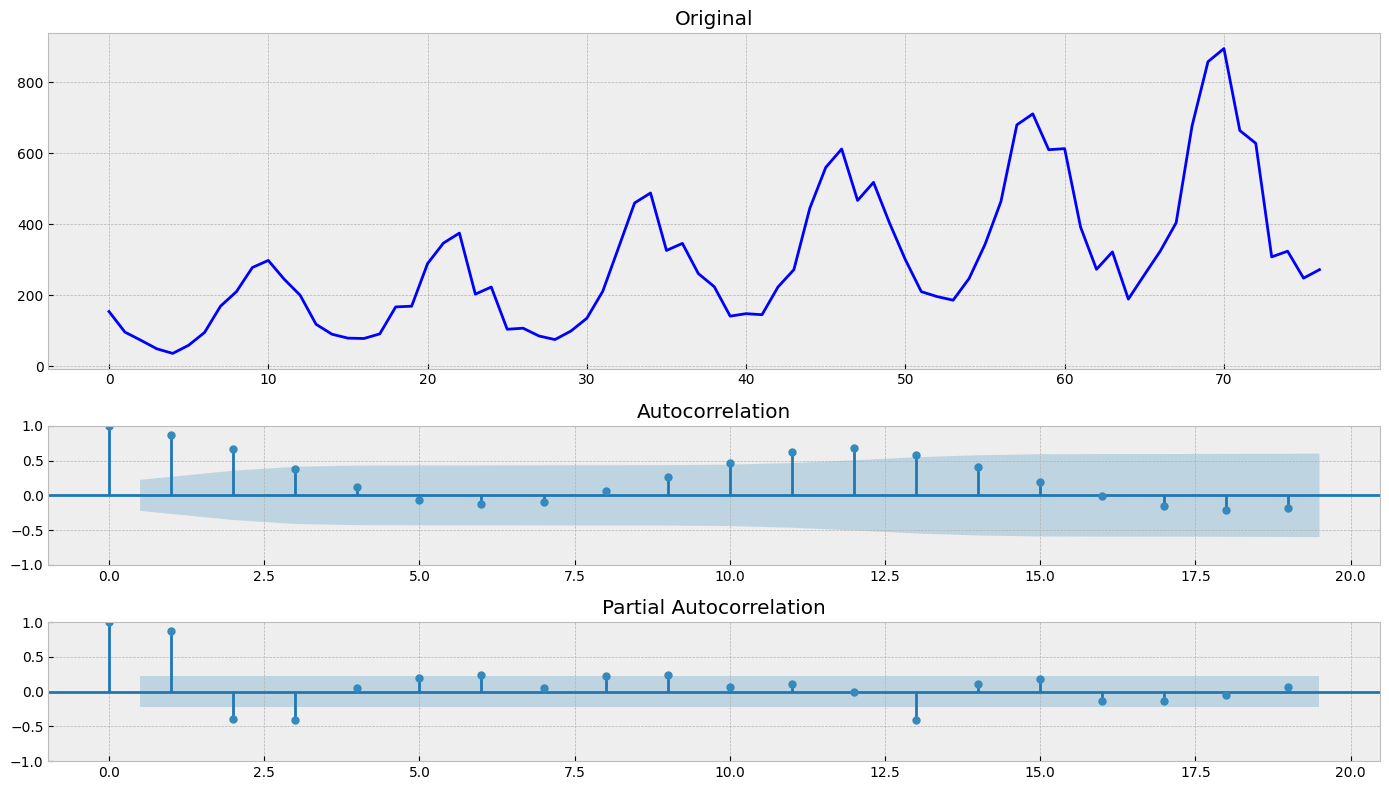

In [6]:
tsplot(series)

## Шаг 1 - матрица траекторий

In [7]:
def embed(x, w):
    """Создает матрицу траекторий из временного ряда."""
    N = len(x)
    return np.column_stack([x[i:i+w] for i in range(N-w+1)])

In [8]:
L = 12
X = embed(series, L)

In [9]:
X

array([[154,  96,  73,  49,  36,  59,  95, 169, 210, 278, 298, 245, 200,
        118,  90,  79,  78,  91, 167, 169, 289, 347, 375, 203, 223, 104,
        107,  85,  75,  99, 135, 211, 335, 460, 488, 326, 346, 261, 224,
        141, 148, 145, 223, 272, 445, 560, 612, 467, 518, 404, 300, 210,
        196, 186, 247, 343, 464, 680, 711, 610, 613, 392, 273, 322, 189,
        257],
       [ 96,  73,  49,  36,  59,  95, 169, 210, 278, 298, 245, 200, 118,
         90,  79,  78,  91, 167, 169, 289, 347, 375, 203, 223, 104, 107,
         85,  75,  99, 135, 211, 335, 460, 488, 326, 346, 261, 224, 141,
        148, 145, 223, 272, 445, 560, 612, 467, 518, 404, 300, 210, 196,
        186, 247, 343, 464, 680, 711, 610, 613, 392, 273, 322, 189, 257,
        324],
       [ 73,  49,  36,  59,  95, 169, 210, 278, 298, 245, 200, 118,  90,
         79,  78,  91, 167, 169, 289, 347, 375, 203, 223, 104, 107,  85,
         75,  99, 135, 211, 335, 460, 488, 326, 346, 261, 224, 141, 148,
        145, 223, 272, 

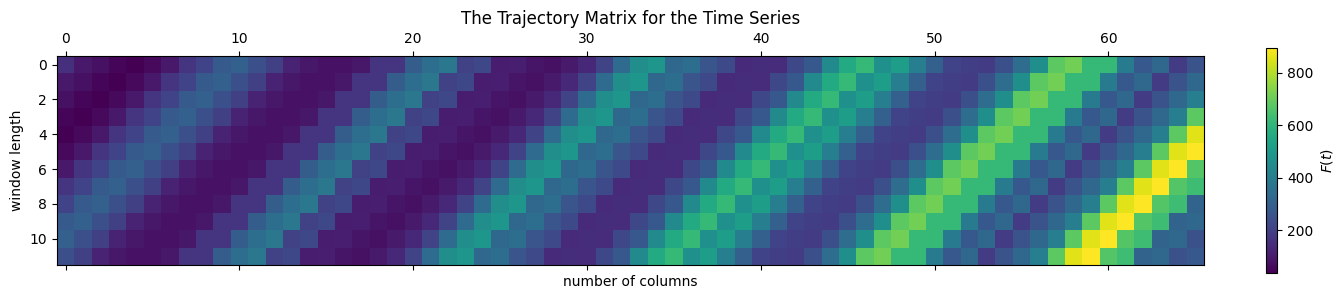

In [10]:
ax = plt.matshow(X)
plt.xlabel("number of columns")
plt.ylabel("window length")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the Time Series");

## Шаг 2 - сингулярное разложение

In [11]:
d = np.linalg.matrix_rank(X)

U, Sigma, V = np.linalg.svd(X)
V = V.T
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

In [12]:
d

12

In [13]:
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

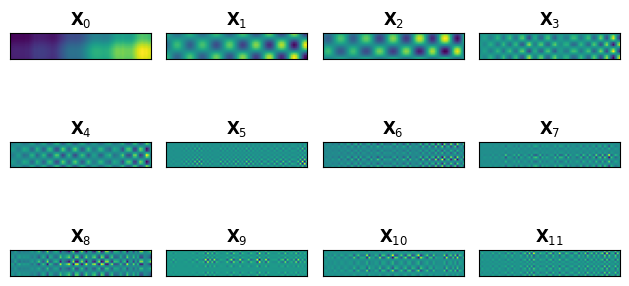

In [15]:
for i in range(d):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

## Шаг 3 - группировка компонентов временного ряда

In [16]:
from cycler import cycler

In [17]:
def X_to_TS(X_i):
    """Усредняет антидиагонали заданной элементарной матрицы X_i и возвращает временной ряд."""
    X_rev = X_i[::-1]
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

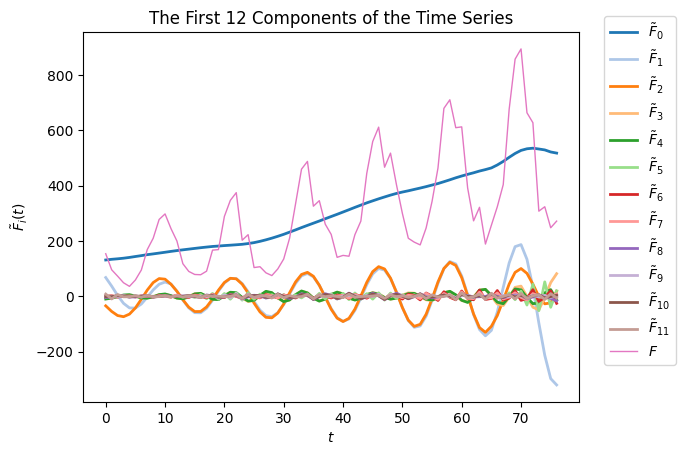

In [18]:
t = np.arange(0,len(series))

fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

for i in range(d):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, series, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components of the Time Series")
fig.legend(legend, loc=(1.05,0.1));

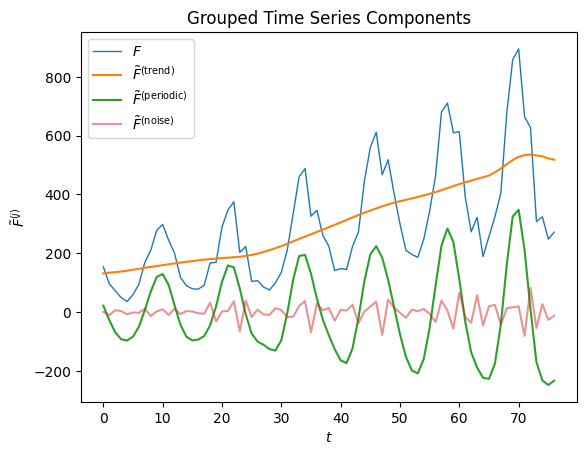

In [23]:
trend = X_to_TS(X_elem[[0]].sum(axis=0))
periodic = X_to_TS(X_elem[[1,2,3,4]].sum(axis=0))
noise = X_to_TS(X_elem[5:].sum(axis=0))

plt.plot(t,series, lw=1)
plt.plot(t, trend)
plt.plot(t, periodic)
plt.plot(t, noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

In [24]:
print("Средняя абсолютная ошибка (MAE):", np.mean(np.abs(noise)))
print("Процент объясненной дисперсии (трендом и сезонностью):",
      100 * (1 - np.var(noise) / np.var(series)))

Средняя абсолютная ошибка (MAE): 22.260141050166837
Процент объясненной дисперсии (трендом и сезонностью): 97.62350767095329


## Эксперименты с длиной окна

### L=3

In [25]:
L = 3
X = embed(series, L)

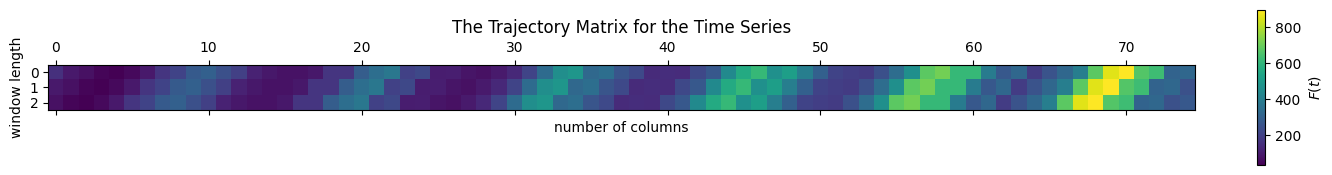

In [26]:
ax = plt.matshow(X)
plt.xlabel("number of columns")
plt.ylabel("window length")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the Time Series");

In [27]:
d = np.linalg.matrix_rank(X)

U, Sigma, V = np.linalg.svd(X)
V = V.T
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

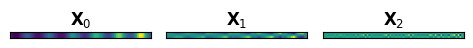

In [28]:
n = min(12, d)
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

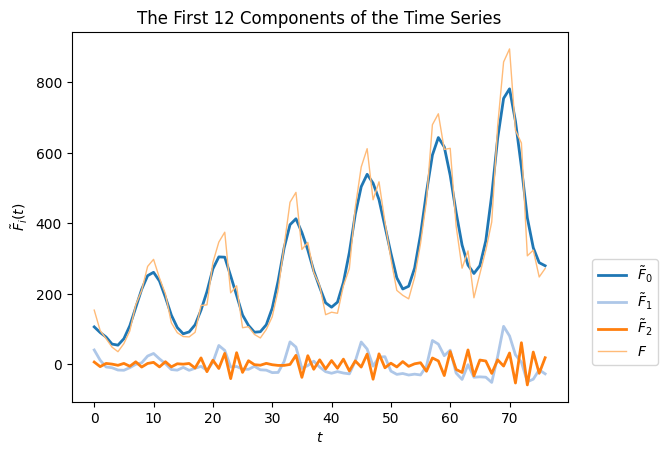

In [29]:
n = min(12,d)
t = np.arange(0,len(series))

fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, series, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components of the Time Series")
fig.legend(legend, loc=(1.05,0.1));

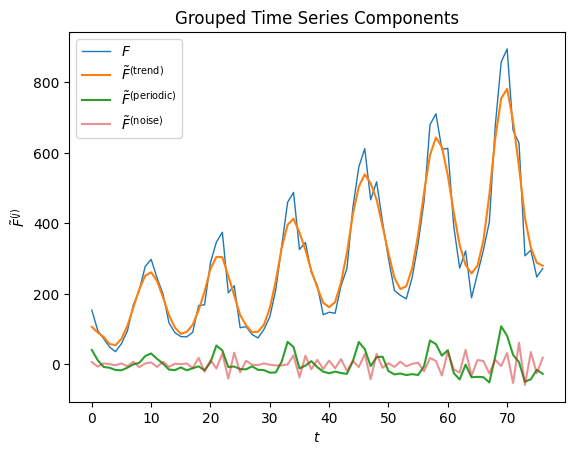

In [30]:
trend = X_to_TS(X_elem[[0]].sum(axis=0))
periodic = X_to_TS(X_elem[[1]].sum(axis=0))
noise = X_to_TS(X_elem[2:].sum(axis=0))

plt.plot(t,series, lw=1)
plt.plot(t, trend)
plt.plot(t, periodic)
plt.plot(t, noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

In [31]:
print("Средняя абсолютная ошибка (MAE):", np.mean(np.abs(noise)))
print("Процент объясненной дисперсии (трендом и сезонностью):",
      100 * (1 - np.var(noise) / np.var(series)))

Средняя абсолютная ошибка (MAE): 15.817404326901839
Процент объясненной дисперсии (трендом и сезонностью): 98.83748639862449


### L=6

In [32]:
L = 6
X = embed(series, L)

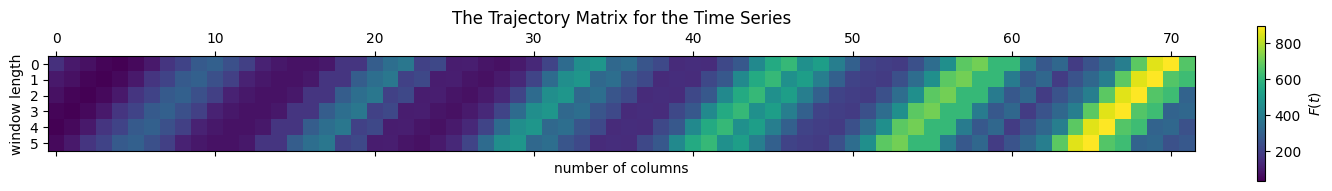

In [33]:
ax = plt.matshow(X)
plt.xlabel("number of columns")
plt.ylabel("window length")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the Time Series");

In [34]:
d = np.linalg.matrix_rank(X)

U, Sigma, V = np.linalg.svd(X)
V = V.T
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

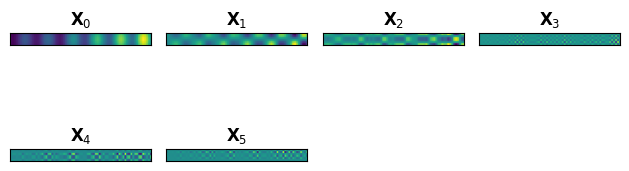

In [35]:
n = min(12, d)
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

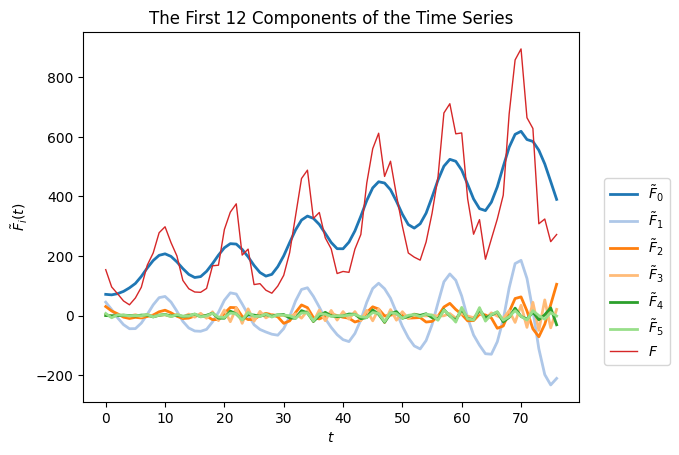

In [36]:
n = min(12,d)
t = np.arange(0,len(series))

fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, series, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components of the Time Series")
fig.legend(legend, loc=(1.05,0.1));

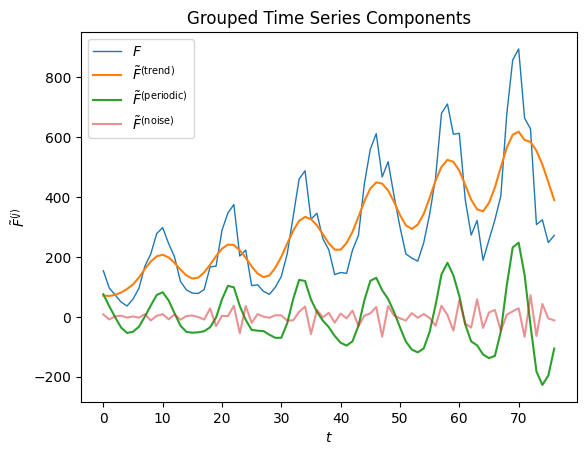

In [37]:
trend = X_to_TS(X_elem[[0]].sum(axis=0))
periodic = X_to_TS(X_elem[[1,2]].sum(axis=0))
noise = X_to_TS(X_elem[3:].sum(axis=0))

plt.plot(t,series, lw=1)
plt.plot(t, trend)
plt.plot(t, periodic)
plt.plot(t, noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

In [38]:

print("Средняя абсолютная ошибка (MAE):", np.mean(np.abs(noise)))
print("Процент объясненной дисперсии (трендом и сезонностью):",
      100 * (1 - np.var(noise) / np.var(series)))

Средняя абсолютная ошибка (MAE): 19.873515127308224
Процент объясненной дисперсии (трендом и сезонностью): 98.06209483534025


### L=9

In [39]:
L = 9
X = embed(series, L)

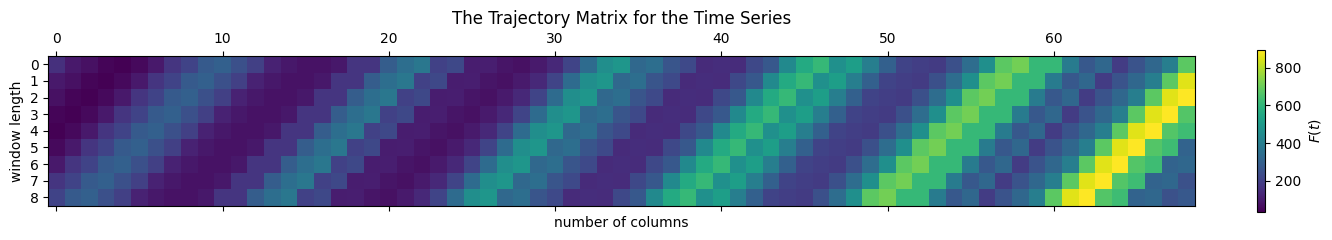

In [40]:
ax = plt.matshow(X)
plt.xlabel("number of columns")
plt.ylabel("window length")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the Time Series");

In [41]:
d = np.linalg.matrix_rank(X)

U, Sigma, V = np.linalg.svd(X)
V = V.T
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

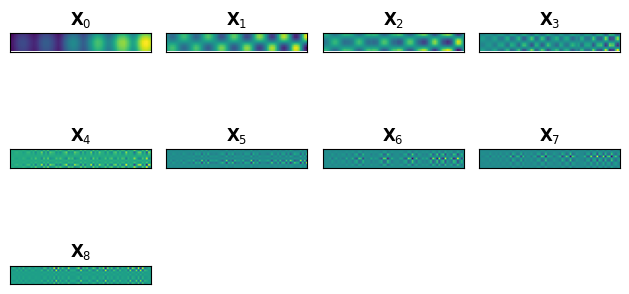

In [42]:
n = min(12, d)
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

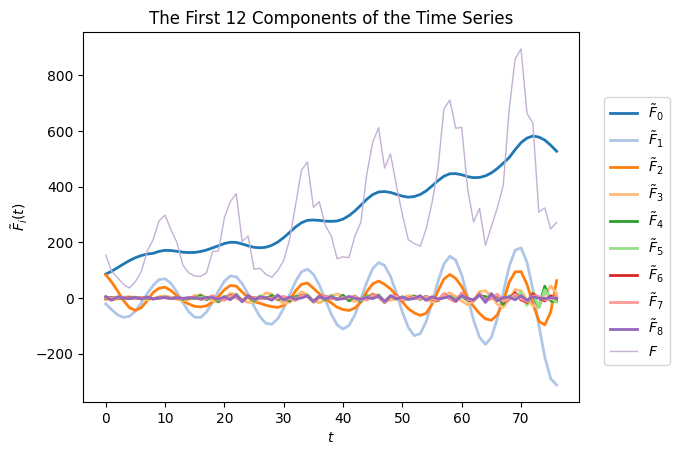

In [43]:
n = min(12,d)
t = np.arange(0,len(series))

fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, series, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components of the Time Series")
fig.legend(legend, loc=(1.05,0.1));

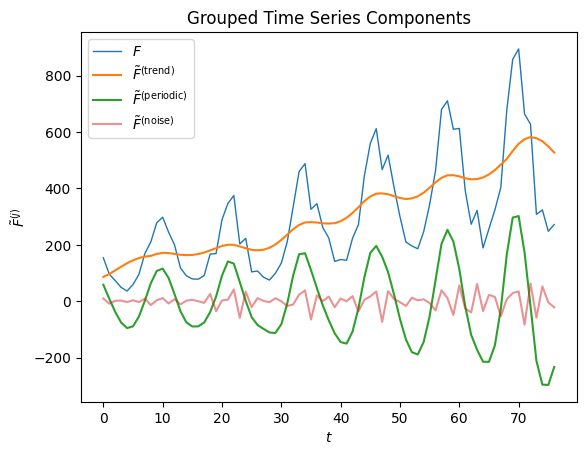

In [44]:
trend = X_to_TS(X_elem[[0]].sum(axis=0))
periodic = X_to_TS(X_elem[[1,2,3]].sum(axis=0))
noise = X_to_TS(X_elem[4:].sum(axis=0))

plt.plot(t,series, lw=1)
plt.plot(t, trend)
plt.plot(t, periodic)
plt.plot(t, noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

In [45]:
print("Средняя абсолютная ошибка (MAE):", np.mean(np.abs(noise)))
print("Процент объясненной дисперсии (трендом и сезонностью):",
      100 * (1 - np.var(noise) / np.var(series)))

Средняя абсолютная ошибка (MAE): 21.468176405910345
Процент объясненной дисперсии (трендом и сезонностью): 97.76477334191055
